# Set up ARTS/Python environment


In [1]:
%env ARTS_INCLUDE_PATH=/home/dudavid/arts/controlfiles/
%env ARTS_DATA_PATH=/home/dudavid/arts/arts-xml/
%env ARTS_BUILD_PATH=/home/dudavid/arts/build/

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from typhon.arts.workspace import Workspace, arts_agenda
ws = Workspace()
ws.execute_controlfile("general/general.arts")
ws.execute_controlfile("general/continua.arts")
ws.execute_controlfile("general/agendas.arts")
ws.execute_controlfile("general/planet_earth.arts")

env: ARTS_INCLUDE_PATH=/home/dudavid/arts/controlfiles/
env: ARTS_DATA_PATH=/home/dudavid/arts/arts-xml/
env: ARTS_BUILD_PATH=/home/dudavid/arts/build/
Loading ARTS API from: /home/dudavid/arts/build//src/arts_api.so


In [2]:
# define absorbing species and sensor (here using metmm library, used again below)
ws.Copy(ws.abs_xsec_agenda, ws.abs_xsec_agenda__noCIA)
ws.abs_speciesSet(species=["H2O-PWR98","O2-PWR93","N2-SelfContStandardType"])
ws.ReadXML( ws.abs_lines, "instruments/metmm/abs_lines_metmm.xml.gz")
ws.abs_lines_per_speciesCreateFromLines()

# General Settings

In [3]:
ws.stokes_dim = 1
ws.iy_unit = "PlanckBT"
ws.cloudboxOff()

# Atmosphere set up

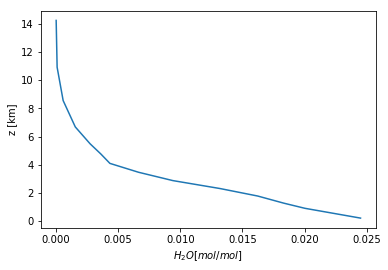

In [4]:
ws.atmosphere_dim = 1  # for 1DVAR
#ws.VectorNLogSpace( ws.p_grid, 20, 1e5, 1e4 ) # 20 levels from 1000 to 100 hPa
p = np.array([1000.,975.,950.,925.,900.,850.,800.,750.,700.,650.,600.,550.,500.,400.,300.,200.,100.])*100.0
ws.p_grid = 0.5 * (p[1:] + p[:-1])
ws.AtmRawRead( basename = "planets/Earth/Fascod/tropical/tropical") #tropical atmosphere assumed
ws.AtmFieldsCalc()
ws.AbsInputFromAtmFields()

ws.z_surface = np.asarray(ws.z_field)[0]
ws.t_surface = np.asarray(ws.t_field)[0]

# plot T, water vapor, N2 and O2 versus altitude
#plt.plot(np.asarray(ws.t_field).ravel(), np.asarray(ws.z_field).ravel() * 1e-3)
#plt.xlabel("T [K]")
#plt.ylabel("z [km]")
plt.plot(np.asarray(ws.vmr_field)[0,:,0,0], np.asarray(ws.z_field).ravel() * 1e-3)
plt.xlabel("$H_2O [mol/mol$]")
plt.ylabel("z [km]")
#plt.plot(np.asarray(ws.vmr_field)[1,:,0,0], np.asarray(ws.z_field).ravel() * 1e-3, label="$O_2$")
#plt.plot(np.asarray(ws.vmr_field)[2,:,0,0], np.asarray(ws.z_field).ravel() * 1e-3, label="$N_2$")
#plt.xlabel("vmr [mol / mol]")
#plt.ylabel("z [km]")
#plt.legend()

# Sensor definition

In [5]:
ws.ArrayOfIndexCreate("channels")
ws.channels = [17,18,19,20,21] # channel index values given in metmm sensor description
ws.ArrayOfIndexCreate("viewing_angles")
ws.viewing_angles = [47] # index of stored viewing angles in metmm file

ws.sensor_pos  = np.array([[850e3]]) # 850km
ws.sensor_time = np.array([0.0])
ws.sensor_los  = np.array([[180.0]]) # nadir viewing

ws.IndexCreate("met_mm_accuracy") 
ws.met_mm_accuracy = 1 # points within each bandwidth to comute abs characteristics

ws.execute_controlfile("instruments/metmm/sensor_descriptions/prepare_metmm.arts")
ws.execute_controlfile("instruments/metmm/sensor_descriptions/sensor_atms.arts")
ws.execute_controlfile("instruments/metmm/sensor_descriptions/apply_metmm.arts")
ws.execute_controlfile("instruments/metmm/common_metmm.arts")

In [6]:
ws.atmfields_checkedCalc( bad_partition_functions_ok = 1 )
ws.abs_xsec_agenda_checkedCalc()
ws.abs_lookupSetup()
ws.abs_lookupCalc()

# Surface 


In [7]:
ws.surface_scalar_reflectivity = np.array([0.5]) # nominal albedo for surface
ws.propmat_clearsky_agenda_checkedCalc()
ws.atmgeom_checkedCalc()
ws.cloudbox_checkedCalc()
ws.sensor_checkedCalc()
ws.jacobianOff()

# Call forward model

In [8]:
ws.yCalc()
ws.y.value # write out TBs for first ycalc

array([ 276.92856134,  270.37567794,  264.02072366,  256.46135151,
        249.86219702])

In [9]:
# now perturb the initial VMR field for water vapor
if not "orig_h2o" in globals().keys():
    orig_h2o = np.array(ws.vmr_field)[0,:,0,0] # save original WV profile (true state)
#np.asarray(ws.vmr_field)[0,:,0,0] = orig_h2o * 1.19 # perturb by x% at all layers
#perturbed = np.copy(ws.vmr_field)[0,:,0,0] # save as 'perturbed' -- will form apriori state



# Set up PCs for retrieval

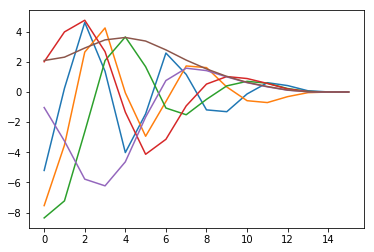

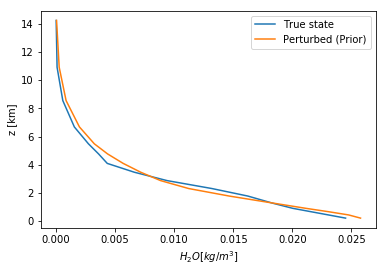

In [20]:
invar = np.loadtxt("pcs.txt") # read in PCs from ascii file
meanwv = invar[0:16][::-1]
A = invar[16:][::-1].reshape(6,16)
for i in range(6):
    plt.plot(A[i,:])
factor = 28.966/18.016 / 1000.0 # convert mixing ratio (g/kg) to vmr (mol/mol)
meanwv = meanwv * factor
A = A * factor
perturbed = meanwv # a priori state is mean profile of PCA

plt.figure()
plt.plot(orig_h2o.ravel(), np.asarray(ws.z_field).ravel() * 1e-3, label="True state")
plt.plot(perturbed, np.asarray(ws.z_field).ravel() * 1e-3, label="Perturbed (Prior)")
plt.xlabel("$H_2O [kg / m^3$]")
plt.ylabel("z [km]")
plt.legend()

# Set up OEM retrieval

In [30]:
ws.retrievalDefInit()
nelem = ws.p_grid.value.size
rvars = np.ones(nelem)*1e1   # define apriori variances of retrieved variables
ws.covmatSetDiagonal(rvars)
ws.retrievalAddAbsSpecies(   # only retrieval variable is abs species, water vapor
 species="H2O-PWR98",
 unit="logrel",
 g1=ws.p_grid,
 g2=ws.lat_grid,
 g3=ws.lon_grid
)
ws.addTransformation(transformation_matrix=A, offset_vector=meanwv)
se_cov = np.zeros(ws.y.value.size) + 0.5**2 # set channel assumed errors
ws.covmatSetDiagonal(se_cov) # diagonal (uncorrelated) errors only for now
ws.covmat_seSet()
ws.retrievalDefClose()

# define inversion iteration as function within python
@arts_agenda
def inversion_iterate_agenda(ws):
    ws.x2artsStandard()  # map x to ARTS's variables
    ws.atmfields_checkedCalc()  # to be safe, rerun checks dealing with atmosph.
    ws.atmgeom_checkedCalc()
    ws.yCalc()  # calculate yf and jacobian matching x
    ws.VectorAddVector( ws.yf, ws.y, ws.y_baseline )  # add baseline term
    ws.jacobianAdjustAfterIteration() 
    # last line takes care of some fixes needed to get the jacobian right for iterative solutions
    
ws.Copy(ws.inversion_iterate_agenda, inversion_iterate_agenda) # copy python function to arts
    
#ws.xaStandard() # set xa to vmr field, effectively 
ws.xa = np.zeros(6) # if supplying user-defined a priori vector
ws.x = np.array([]) # create empty vector for retrieved state vector?
ws.yf = np.array([]) # create empty vector for simulated TB?
ws.jacobian = np.array([[]])


# Run OEM retrieval

In [31]:
ws.OEM(method="lm",
    max_iter=1000,
    display_progress=1,
    max_start_cost=1e3,
    lm_ga_settings=np.array([10.0,2.0,2.0,100.0,1.0,99.0])
       )
ws.x2artsStandard() # convert from ARTS coords back to user-defined grid

Exception: Call to ARTS WSM OEM failed with error: Inconsistency in size between *x* and *covmat_sx*.

In [13]:
# save resultant WV profile to 'retrieved'
retrieved = np.copy(ws.vmr_field)[0,:,0,0]

# Look at results

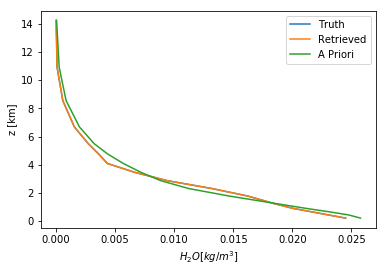

In [14]:
plt.plot(orig_h2o, np.asarray(ws.z_field).ravel() * 1e-3, label="Truth")
plt.plot(retrieved, np.asarray(ws.z_field).ravel() * 1e-3, label="Retrieved")
plt.plot(perturbed, np.asarray(ws.z_field).ravel() * 1e-3, label="A Priori")
plt.xlabel("$H_2O [kg / m^3$]")
plt.ylabel("z [km]")
#plt.xscale("log")
plt.legend()

In [15]:
# compare simulated and 'observed' TB from 
residual = ws.y.value - ws.yf.value
residual 

array([ 0.,  0.,  0.,  0.,  0.])

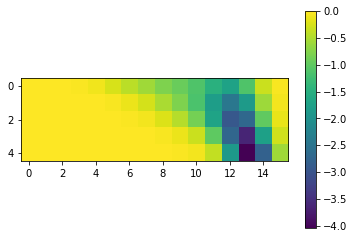

In [16]:
# plot jacobian -- should show sensitivity in middle troposphere
plt.imshow(ws.jacobian)
plt.colorbar()

3.8398380452222618

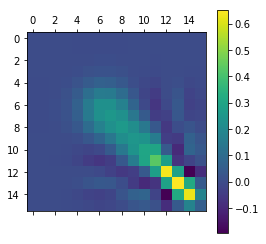

In [17]:
ws.avkCalc() # calculate averaging kernel (A-matrix)
plt.matshow(ws.avk)
plt.colorbar()
np.diag(ws.avk)
sum(np.diag(ws.avk)) # print trace of A-matrix, aka degrees of freedom for signal (DFS)

In [18]:
# calculate posterior covariance matrices of observations and a priori
ws.covmat_soCalc() # observation covariance matrix
ws.covmat_ssCalc() # smoothing covariance matrix

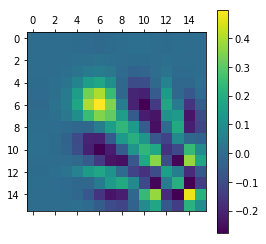

In [19]:
# plot posterior observation covariance matrix
plt.matshow(ws.covmat_so)
plt.colorbar()